In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


This notebook contains code to reproduce the following from Mitra, et al.:

**Main Figures:** 
* Figure 2D: Mutations of mutation rate

In [6]:
# Input per-locus info
LOCFILE = "/storage/mgymrek/ssc-denovos/denovos_GW_priors_Jan20/SSC_allphases_011720_denovos_GW_priors_Aug20.locus_stats_rmoutlierfams.tab"

# Make editable in Illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats
import statsmodels.discrete.discrete_model
import statsmodels.api as sm

# Other data paths
ANNOTFILE = "/storage/mgymrek/ssc-denovos/annotations/hg38_gangstr_MasterAnnotation-rmdup.bed"

# Color keys
colors = ['gray','red','gold','blue','green','purple','brown','salmon','magenta','cyan','darkblue']

# Output path info
OUTDIR = "pdfs/"

In [7]:
# Load per-locus mutation info
data = pd.read_csv(LOCFILE, delim_whitespace=True)

# Load annotation info
annot = pd.read_csv(ANNOTFILE, sep="\t")

# Set up fields
def GetChrom(x):
    if "chr" in str(x): return int(x[3:])
    else: return int(x)
data["chrom"] = data["chrom"].apply(GetChrom)
annot = annot[annot["chrom"].apply(lambda x: x not in ["X","chrX","Y","chrY"])]
annot["chrom"] = annot["chrom"].apply(GetChrom)
annot["pos"] = annot["start"]

# Merge
adata = pd.merge(data, annot, on=["chrom","pos"])

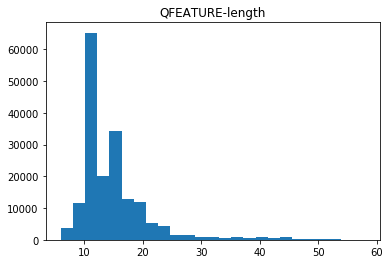

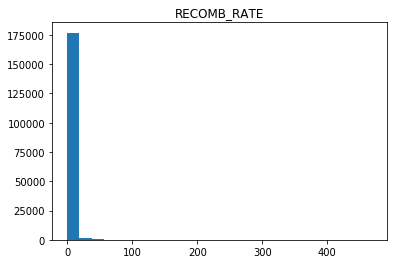

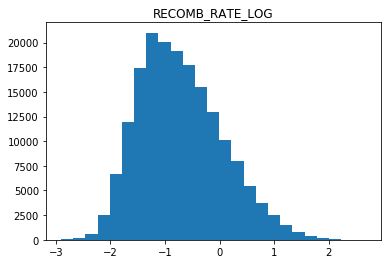

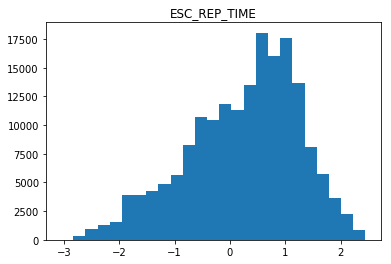

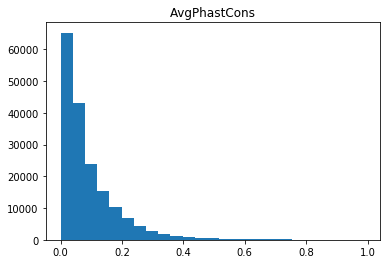

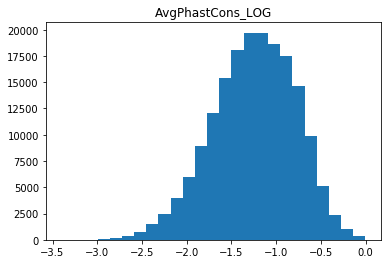

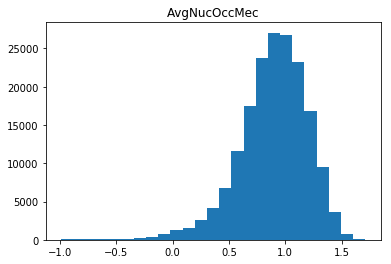

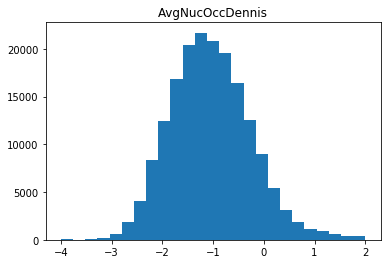

In [8]:
# Scale and remove outliers based on what we learned below
adata["RECOMB_RATE_LOG"] = np.log10(adata["RECOMB_RATE"]+0.0001)
adata = adata[adata["RECOMB_RATE_LOG"]>-3]

adata["AvgPhastCons_LOG"] = np.log10(adata["AvgPhastCons"]+0.0001)
adata = adata[adata["AvgPhastCons_LOG"]>-4]

adata = adata[adata["AvgNucOccMec"]>-1]
adata = adata[(adata["AvgNucOccDennis"]>-4) & (adata["AvgNucOccDennis"]<2)]

adata = adata[adata["QFEATURE-length"]<60]
# Explore each feature
for col in ['QFEATURE-length','RECOMB_RATE', 'RECOMB_RATE_LOG',
             'ESC_REP_TIME',
            'AvgPhastCons', "AvgPhastCons_LOG",
       'AvgNucOccMec',  'AvgNucOccDennis']:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(adata[~np.isnan(adata[col])][col], bins=25)
    ax.set_title(col)

In [9]:
# Fit model separately for each period

USECOLS = [# quantitative 
    "QFEATURE-length","QFEATURE-GCmotif","QFEATURE-GC50",
    "QFEATURE-GC100","QFEATURE-GC1000","QFEATURE-GC10000", 'RECOMB_RATE_LOG', 
     'ESC_REP_TIME', 'AvgPhastCons_LOG', 'AvgNucOccMec', 'AvgNucOccDennis',
    # binary
    "FEATURE-DNASE10","FEATURE-DNASE100","FEATURE-DNASE1000","FEATURE-DNASE10000",
    'FEATURE-H1_H3K27ac', 'FEATURE-H1_H3K4me1', 'FEATURE-H1_H3K4me3',
    'FEATURE-CONSPROMOTER'
          ]

def ZNorm(vals):
    m = np.mean(vals)
    sd = np.sqrt(np.var(vals))
    return [(item-m)/sd for item in vals]

coeffs_single = {}
coeffs_single_pvals = {}
coeffs_single_errs = {}
means = {} # period -> mean values

for period in range(1, 7):
    print("#### Period %s ######"%period)
    
    if period < 6:
        xdata = adata[adata["period"]==period].copy()
    else: xdata = adata[adata["period"]>= period].copy()
        
    # Get means
    means[period] = []
    for col in USECOLS:
        means[period].append(np.mean(xdata[col]))
        
    # Znorm all cols used
    for col in USECOLS:
        if len(set(xdata[col]))>1: # don't perform if all the same value
            xdata[col] = ZNorm(xdata[col])
    
    Y = np.array(xdata["mut_unaff"])
    T = np.array(xdata["all_unaff"])
    
    # Single models (but control for length)
    coeffs_single[period] = []
    coeffs_single_pvals[period] = []
    coeffs_single_errs[period] = []
    for col in USECOLS:
        if "length" in col:
            X = np.array(xdata[col])
            ind = 1
        else:
            if len(set(xdata[col]))==1:
                coeffs_single[period].extend([np.nan])
                coeffs_single_pvals[period].extend([np.nan])
                coeffs_single_errs[period].extend([np.nan])
                continue
            X = np.array(xdata[["QFEATURE-length",col]])
            ind = 2
        X = sm.add_constant(X)
        model = statsmodels.discrete.discrete_model.Poisson(Y, X, exposure=T)
        mfit = model.fit()
        
        
        coeffs_single[period].extend(mfit.params[ind:])
        coeffs_single_pvals[period].extend(mfit.pvalues[ind:])
        coeffs_single_errs[period].extend(np.sqrt(np.diag(mfit.cov_params())[ind:]))

#### Period 1 ######
Optimization terminated successfully.
         Current function value: 0.429461
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425201
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.429413
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429289
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429210
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429441
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429160
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429370
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429138
         Iterations 7
Optimization terminated successfully.
         Current funct

/storage/resources/source/anaconda2/envs/py37/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.081850
         Iterations 28
Optimization terminated successfully.
         Current function value: 0.081452
         Iterations 28
Optimization terminated successfully.
         Current function value: 0.081906
         Iterations 28
Optimization terminated successfully.
         Current function value: 0.081824
         Iterations 28
#### Period 4 ######
Optimization terminated successfully.
         Current function value: 0.070933
         Iterations 29
Optimization terminated successfully.
         Current function value: 0.070846
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.070691
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.070766
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.070927
         Iterations 29
Optimization terminated successfully.
         Curre

/storage/resources/source/anaconda2/envs/py37/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.070812
         Iterations 29
Optimization terminated successfully.
         Current function value: 0.070917
         Iterations 29
Optimization terminated successfully.
         Current function value: 0.070929
         Iterations 29
#### Period 5 ######
Optimization terminated successfully.
         Current function value: 0.047224
         Iterations 31
Optimization terminated successfully.
         Current function value: 0.047224
         Iterations 31
Optimization terminated successfully.
         Current function value: 0.046484
         Iterations 31
Optimization terminated successfully.
         Current function value: 0.046965
         Iterations 31
Optimization terminated successfully.
         Current function value: 0.047158
         Iterations 31
Optimization terminated successfully.
         Current function value: 0.047169
         Iterations 31
Optimization terminated successfully.
         Curre

/storage/resources/source/anaconda2/envs/py37/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.047191
         Iterations 31
         Current function value: 0.046945
         Iterations: 35


/storage/resources/source/anaconda2/envs/py37/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.047223
         Iterations 31
         Current function value: 0.047166
         Iterations: 35
#### Period 6 ######


/storage/resources/source/anaconda2/envs/py37/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.043438
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.043348
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.043428
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.043396
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.043383
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.043393
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.043282
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.043385
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.043404
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.

/storage/resources/source/anaconda2/envs/py37/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.043438
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.043298
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.043124
         Iterations 28


In [10]:
# Make single dataframe with results

periods = []
models = []
coeffs = []
pvals = []
cols = []
errs = []
meanvals = []

# for period in range(1, 7):
for period in range(1, 7):
    m = means[period]
    cs = coeffs_single[period]
    ps = coeffs_single_pvals[period]
    es = coeffs_single_errs[period]
    periods.extend([period]*len(cs))
    models.extend(["Single"]*len(cs))
    coeffs.extend(cs)
    pvals.extend(ps)
    errs.extend(es)
    cols.extend(USECOLS)
    meanvals.extend(m)
    
res = pd.DataFrame({"period": periods, "model": models,
                   "coeff": coeffs, "pval": pvals, "feature": cols,
                   "err": errs, "means": meanvals})
res["Z"] = res["coeff"]/res["err"]
res[res["period"]==2]

,period,model,coeff,pval,feature,err,means,Z
19,2,Single,1.092301,0.000000e+00,QFEATURE-length,0.014452,20.396699,75.581087
20,2,Single,-0.259322,7.651987e-26,QFEATURE-GCmotif,0.024670,0.403343,-10.511435
21,2,Single,-0.052787,3.584192e-03,QFEATURE-GC50,0.018124,0.388379,-2.912612
22,2,Single,-0.009231,6.034924e-01,QFEATURE-GC100,0.017772,0.393986,-0.519385
23,2,Single,0.028217,8.679155e-02,QFEATURE-GC1000,0.016477,0.406529,1.712571
24,2,Single,0.035456,2.998756e-02,QFEATURE-GC10000,0.016337,0.411424,2.170255
25,2,Single,0.004952,7.618533e-01,RECOMB_RATE_LOG,0.016342,-0.695160,0.303048
26,2,Single,0.065277,9.680669e-05,ESC_REP_TIME,0.016744,0.076197,3.898459
27,2,Single,0.018457,2.763437e-01,AvgPhastCons_LOG,0.016955,-1.274372,1.088570
28,2,Single,-0.021157,2.531498e-01,AvgNucOccMec,0.018514,0.789962,-1.142732


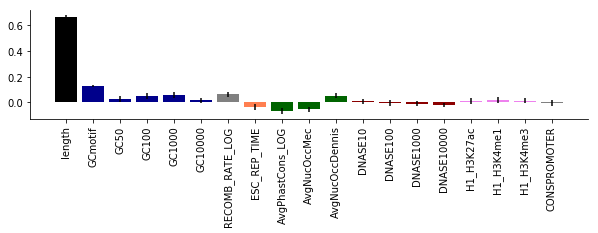

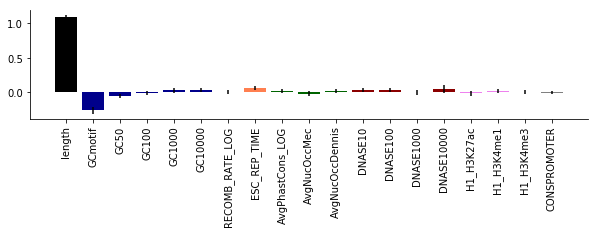

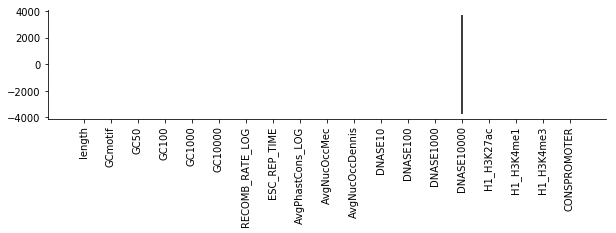

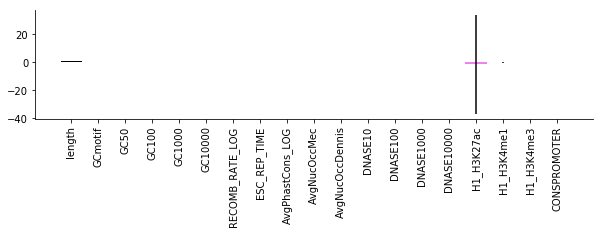

In [11]:
catcols = []
for col in USECOLS:
    if "length" in col:
        catcols.append("black")
    elif "GC" in col:
        catcols.append("darkblue")
    elif "DNASE" in col:
        catcols.append("darkred")
    elif "ChromHMM" in col:
        catcols.append("darkcyan")
    elif "H1" in col:
        catcols.append("violet")
    elif "TIME" in col:
        catcols.append("coral")
    elif "Avg" in col:
        catcols.append("darkgreen")
    else:
        catcols.append("gray")
        
for period in range(1, 5):
    r = res[(res["period"]==period) & (res["model"]=="Single")]
    fig = plt.figure()
    fig.set_size_inches((10, 2))
    ax = fig.add_subplot(111)
    ax.bar(range(r.shape[0]), r["coeff"], yerr=r["err"]*1.96, color=catcols)
    ax.set_xticks(range(r.shape[0]))
    ax.set_xticklabels(r["feature"].apply(lambda x: x.split("-")[1] if "-" in x else x))
    #ax.set_title("Period=%s"%period)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    #ax.set_ylim(bottom=-0.5, top=1.2)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    #ax.set_xticklabels([])
    fig.savefig(os.path.join(OUTDIR,"Figure2_MutationDeterminants_period%s.pdf"%period))